# Linear regression using normal equation  

Data: California housing data  
Training: Linear regression with normal equation and cross-validation  
Evaluation: R2 score and cross_val_score with different scoring parameters.  

In [ ]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, learning_curve, ShuffleSplit
from sklearn.metrics import mean_squared_error

In [ ]:
np.random.seed(306)
plt.style.use('seaborn')

We will use `ShuffleSplit` crossvalidation with:  
> 10 folds (`n_splits`) and  
> set aside 20% examples as test examples (`test_size`)  

In [ ]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

## **STEP 1:** Load the dataset  

In [ ]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

In [ ]:
print(f'Shape of feature matrix: {features.shape}')
print(f'Shape of label vector: {labels.shape}')

Shape of feature matrix: (20640, 8)
Shape of label vector: (20640,)


In [ ]:
assert(features.shape[0] == labels.shape[0])

## **STEP 2:** Data exploration

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [ ]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000


## **STEP 3:** Data preprocessing and model building

### 3.1 Train test split

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)

In [ ]:
print(f'No. of training samples: {train_features.shape[0]}')
print(f'No. of test samples: {test_features.shape[0]}')

No. of training samples: 15480
No. of test samples: 5160


In [ ]:
assert(train_features.shape[0] == train_labels.shape[0])
assert(test_features.shape[0] == test_labels.shape[0])

### 3.2 Pipeline: Data preprocessing + model  

We will use `StandardScaler` feature scaling to bring all features on the same scale followed by a `LinearRegression` model.  

The `Pipeline` object has two components:
> StandardScaler as step 1  
> LinearRegression as step 2

In [ ]:
# Set up the linear regression model
lin_reg_pipeline = Pipeline([('feature_scaling', StandardScaler()),
                             ('lin_reg', LinearRegression())])

# Train linear regression model with normal equation
lin_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])

Now that we have trained the model, let's check the learnt/estimated weight vectors (`intercept_`, `coef_`)

In [ ]:
print(f'intercept (w0): {lin_reg_pipeline[-1].intercept_}')
print(f'weight vector (w1, w2...wm:): {lin_reg_pipeline[-1].coef_}')

intercept (w0): 2.0703489205426377
weight vector (w1, w2...wm:): [ 0.85210815  0.12065533 -0.30210555  0.34860575 -0.00164465 -0.04116356
 -0.89314697 -0.86784046]


Few things to notice:  
> We accessed the LinearRegression object as lin_reg_pipelin[-1] which is the last step in the pipeline.  
> The intercept can be obtained via intercept_ member variable and  
> The weight vector corresponding to features via coef_

## **STEP 4:** Model evaluation  

Let's use `score` method to obtain train and test errors with twin objectives:  
> Estimation of model performance as provided by test error.  
> Comparison of errors for model diagnostic purpose (under/over/just right fit).  

In [ ]:
# Evaluate model performance on the test set.
test_score = lin_reg_pipeline.score(test_features, test_labels)
print('Model performance on test set:', test_score) 

train_score = lin_reg_pipeline.score(train_features, train_labels)
print('Model performance on train set: ', train_score)

Model performance on test set: 0.5910509795491352
Model performance on train set:  0.609873031052925


The `score` returns r2 score whose best value is 1. The r2 scores on training and test are comparable but they are not that high. it points to unfderfitting in model training.

## Cross-validated score (cross_val_score)  

Since the `score` was computed on one fold that was selected as my test set, it may not be all that robust. In order to obtain robust estimate of the performance, we use cross_val_score that calculates `score` on different test folds through crossvalidation.  

In [ ]:
lin_reg_score = cross_val_score(lin_reg_pipeline,
                                train_features,
                                train_labels,
                                scoring='neg_mean_squared_error', 
                                cv=shuffle_split_cv)

# This will return 10 different scores, one for each fold  

print(lin_reg_score)

# We can take mean and standard deviation of the score and report it.  
print(f'\nScore of linear regression model on the test set:\n'
      f'{lin_reg_score.mean():.3f} +/- {lin_reg_score.std():.3f}')

[-0.50009976 -0.52183352 -0.55931218 -0.52110499 -0.56059203 -0.50510767
 -0.52386194 -0.54775518 -0.5007161  -0.54713448]

Score of linear regression model on the test set:
-0.529 +/- 0.022


Here we got the negative mean squared error as score. We can convert that to error as follows:  

In [ ]:
lin_reg_mse = -lin_reg_score
print(f'MSE of linear regression model on the test set:\n'
f'{lin_reg_mse.mean():.3f} +/- {lin_reg_mse.std():.3f}')

MSE of linear regression model on the test set:
0.529 +/- 0.022


We can use other `scoring` parameters and obtain cross-validated scores based on that parameter. The following choices are available for `scoring`:  

> explained_variance  
> max_error  
> neg_mean_absolute_error  
> neg_root_mean_squared_error  
> neg_mean_squared_log_error  
> neg_median_absolute_error  
> neg_mean_absolute_percentage_error  
> r2

## Cross-validation  

We just calculated `cross_val_score` based on the cross validation. It however returns only scores for each fold. What if we also need to access the models trained in each fold along with some other statistics like train error for that fold?  

> `cross_validate` API enables us to obtain them.  

In [ ]:
lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    train_features,
                                    train_labels,
                                    cv=shuffle_split_cv,
                                    scoring="neg_mean_squared_error",
                                    return_train_score=True,
                                    return_estimator=True)

The `lin_reg_cv_results` is a dictionary with the following contens:  
* trained `estimators`,  
* time taken for fitting (`fit_time`) and scoring (`score_time`) the models in cross validation,  
* training scores (`train_score`) and  
* test scores (`test_score`)  

Let's print the contents of the dictionary for us to examine.  

In [ ]:
lin_reg_cv_results

{'estimator': [Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]

There are 10 values in each dictionary key. That is because of `cv=10` or 10-fold cross validation that we used.  

We compare training and test errors to access generalization performance of our model. However, we have training and test scores in the `cv_results` dictionary.  

> Multiply these scores by -1 and convert them to errors.  

In [ ]:
train_error = -1 * lin_reg_cv_results['train_score']
test_error = -1 * lin_reg_cv_results['test_score']

print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the train set:
0.519 +/- 0.006
Mean squared error of linear regression model on the test set:
0.529 +/- 0.022


* The training and test errors are high, which is an indication of underfitting, which we will confirm by plotting the learning curves.  
* Test error has higher variability across different folds compared to the train error.  

## Effect of training set size on error  

Let's understand how the training set size or #samples affect the error. We can use `learning_curve` API that calculates cross validation scores for different #samples as specified in its argument `train_sizes`.  

In [ ]:
#@title [Plot learning curves]
def plot_learning_curves(train_sizes, train_scores, test_scores):

  train_scores_mean = np.mean(-train_scores, axis=1)
  train_scores_std = np.std(-train_scores, axis=1)
  test_scores_mean = np.mean(-test_scores, axis=1)
  test_scores_std = np.std(-test_scores, axis=1)
  fit_times_mean = np.mean(fit_times, axis=1)
  fit_times_std = np.std(fit_times, axis=1)

  plt.fill_between(
      train_sizes,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.1,
      color="r")

  plt.fill_between(
      train_sizes,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.1,
      color="g")
  
  plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
  plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
  plt.xlabel("Training examples")
  plt.ylabel("MSE")
  plt.legend(loc="best")

Based on the scores calculated by `learning_curve` API, we plot the error and its standard deviation for different #samples.  

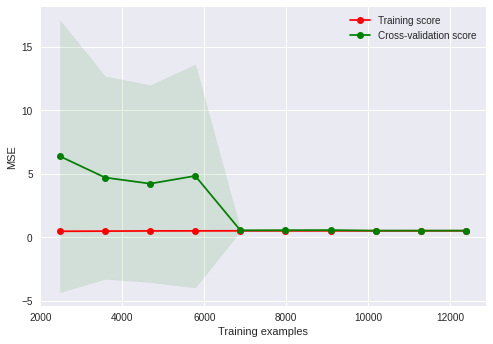

In [ ]:
(train_sizes, train_scores, test_scores, fit_times, score_times) = \
  learning_curve(
      lin_reg_pipeline, train_features, train_labels, cv=shuffle_split_cv,
      scoring="neg_mean_squared_error", n_jobs=-1,
      return_times=True, train_sizes=np.linspace(0.2, 1.0, 10))
  
plot_learning_curves(train_sizes, train_scores, test_scores)

Observe that  
* Both curves have reached a plateau; they are close and fairly high.  
* Few instances in the training set means the model can fit them perfectly. But as more instances are added to the training set, it becomes impossible for the model to fit the training data perfectly.  
* When the model is trained on very few training instances, it is not able to generalize properly, which is why the validation error is initially quite high. Then as the model learns more training examples, the training and validation error reduce slowly.  

These learning curves are typical of an **underfitting** model.  


We can also study how model training scales as the function of number of training samples.  

> Code of this function not available. Watch [video](https://www.youtube.com/watch?v=ddRlrZ_2JvU) at 22:53.

In [ ]:
plot_scalability_curve(train_sizes, fit_times)

NameError: ignored

## Model examination  


Let's examine the weight vectors and how much variability exists between them across different cross-validated models.  

In [ ]:
feature_names = train_features.columns
feature_names

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

For this, we first construct a dataframe of weight vectors and plot them with `box` plot.  

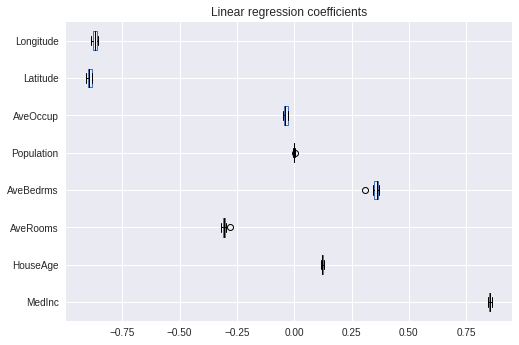

In [ ]:
coefs = [est[-1].coef_ for est in lin_reg_cv_results["estimator"]]
weights_df = pd.DataFrame(coefs, columns=feature_names)

color = {"whiskers": "black", "medians":"black", "caps": "black"}
weights_df.plot.box(color=color, vert=False)    #, figsize=(6,16))
_ = plt.title("Linear regression coefficients")

Theres is not much variability in weights learned by different models. It can also be seen by using the standard deviation of weights as seen in `std` row below.  

In [ ]:
weights_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.852153,0.122770,-0.304384,0.353528,-0.001576,-0.037059,-0.894011,-0.869753
std,0.005763,0.004312,0.010998,0.018044,0.003254,0.008582,0.009975,0.009097
min,0.843517,0.117394,-0.318971,0.307474,-0.005787,-0.047584,-0.908058,-0.884206
25%,0.848871,0.119895,-0.310778,0.349715,-0.002688,-0.042486,-0.901411,-0.876542
50%,0.852711,0.121592,-0.305795,0.360139,-0.002063,-0.042325,-0.895370,-0.869631
75%,0.854743,0.125520,-0.302980,0.364646,-0.000350,-0.027562,-0.883967,-0.862110
max,0.861659,0.130560,-0.278426,0.367952,0.005297,-0.026331,-0.881884,-0.857844


## Selecting the best model  


Let's select the model with the lowest cross validation test error as the best performing model.  

In [ ]:
# Let's find out the best model that resulted in the least test error. 
best_model_index = np.argmin(test_error)
selected_model = lin_reg_cv_results["estimator"][best_model_index]

Let's examine the model coefficients.

In [ ]:
print(f"Intercept (w_0): {selected_model['lin_reg'].intercept_}")
print(f"Coefficients (w_1, w_2, ..., w_m): {selected_model['lin_reg'].coef_}")

Intercept (w_0): 2.0779898917958657
Coefficients (w_1, w_2, ..., w_m): [ 8.44324888e-01  1.18463901e-01 -3.04619574e-01  3.56620503e-01
  1.74458509e-04 -4.23964612e-02 -8.96045642e-01 -8.68906479e-01]


# Model performance

Towards this, let's first obtain the predictions for test points in cross validation.  

In [ ]:
from sklearn.model_selection import cross_val_predict
cv_predictions = cross_val_predict(lin_reg_pipeline, train_features, train_labels)

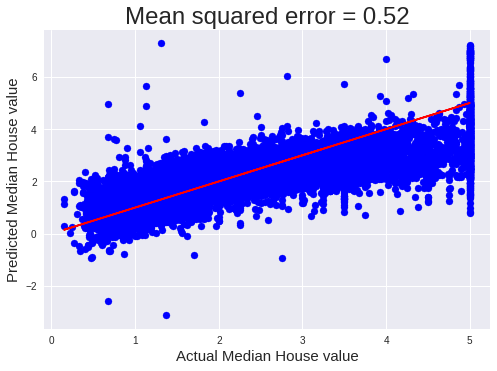

In [ ]:
mse_cv = mean_squared_error(train_labels, cv_predictions)
                            
plt.scatter(train_labels, cv_predictions, color="blue")
plt.plot(train_labels, train_labels, "r-")
plt.title(f"Mean squared error = {mse_cv:.2f}", size=24)
plt.xlabel("Actual Median House value", size=15)
plt.ylabel("Predicted Median House value", size=15)
plt.show()

* The model seems to be all over the place in its predictions for examples with label 5.  
* There are some negative predictions. We can fix this by adding a constraing on weights to be positive.  

At this stage, we should perform error analysis and check where the predictions are going wrong. We can revisit feature construction, preprocessing or model stages and make the necessary course corrections to get better performance.  

# Step #5: Predictions

We can use the best performing model from cross validation for getting predictions on the test set.

In [ ]:
test_predictions_cv = selected_model.predict(test_features)
test_predictions_cv[:5]

array([0.73548515, 1.7725621 , 2.70011199, 2.83716602, 2.60743151])

We can also obtain predictions using the initial model that we built without cross validation.

In [ ]:
test_predictions = lin_reg_pipeline.predict(test_features)
test_predictions[:5]

array([0.72412832, 1.76677807, 2.71151581, 2.83601179, 2.603755  ])

# Step #6: Report model performance


We report model performance on the test set.

In [ ]:
score_cv = selected_model.score(test_features, test_labels)
score = lin_reg_pipeline.score(test_features, test_labels)

print(f"R2 score for the best model obtained via cross validation: {score_cv}")
print(f"R2 score for model without cross validation: {score}")

R2 score for the best model obtained via cross validation: 0.5923577635319088
R2 score for model without cross validation: 0.5910509795491352


Alternatively we can use any other metric of interest and report performance based on that. For example, the mean squared error is as follows:

In [ ]:
mse = mean_squared_error(test_labels, test_predictions)
mse_cv = mean_squared_error(test_labels, test_predictions_cv)

print(f"MSE for the best model obtained via cross validation: {mse_cv}")
print(f"MSE for model without cross validation: {mse}")

MSE for the best model obtained via cross validation: 0.5393995876218523
MSE for model without cross validation: 0.5411287478470688


The cross validation model has slightly better MSE than the other model.

**Exercise:** 
1. Change the scoring scheme to other scoring metrics provided in `sklearn.metrics` and compare results across different metrics.  
2. Repeat the modeling steps with `SGDRegressor`.